## K-means clustering performed on all nine channels (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel1/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       818180       472174       470850
Actual 1         2912         2095         2485
Actual 2         3012         1757         5763
Accuracy - Combined Labels: 0.46426764866560105




## K-means clustering performed on all channels - S7 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel1/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       785166       487875       489155
Actual 1         3315         1165         3056
Actual 2         4524         2802         3174
Accuracy - Combined Labels: 0.4434843323791506




## K-means clustering performed on all channels - S4 and S7 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel1/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       506118       905494       351441
Actual 1         1476         3202         2725
Actual 2         3143         7007          555
Accuracy - Combined Labels: 0.2862599169867294




## K-means clustering performed on all channels - S4 (min-max calculated for each channel, rescaled data calculated for each channel)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc','S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel1/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       911562       352354       498280
Actual 1         3457         1698         2381
Actual 2         5071         1638         3791
Accuracy - Combined Labels: 0.5151300504653326




In [2]:
total_elements = np.prod(cluster_labels_clean.shape)
cloud_elements = np.sum(cluster_labels_clean == 0)
cloud_percentage = (cloud_elements / total_elements) * 100
print(f"Percentage of domain identified as cloud: {cloud_percentage:.2f}%")

Percentage of domain identified as cloud: 51.12%


In [4]:
total_elements = np.prod(cluster_labels_clean.shape)
clear_elements = np.sum(cluster_labels_clean == 1)
clear_percentage = (clear_elements / total_elements) * 100
print(f"Percentage of domain identified as clear: {clear_percentage:.2f}%")

Percentage of domain identified as clear: 19.76%


In [5]:
total_elements = np.prod(cluster_labels_clean.shape)
ice_elements = np.sum(cluster_labels_clean == 2)
ice_percentage = (ice_elements / total_elements) * 100
print(f"Percentage of domain identified as ice: {ice_percentage:.2f}%")

Percentage of domain identified as ice: 28.03%


In [7]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean, rescaled_data

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc','S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean, rescaled_data = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel1/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       348634       508587       904975
Actual 1         1682         2415         3439
Actual 2         1624         3873         5003
Accuracy - Combined Labels: 0.20000314565741995




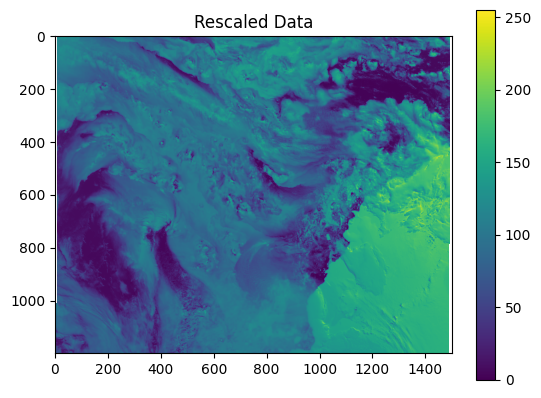

In [17]:
# Histograms
def plot_histogram(data, title):
    plt.hist(data.flatten(), bins=100)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

channel_index = 0  # Choose any channel index
plot_histogram(ds_combined[channel_index].values, 'Original Data')
plot_histogram(rescaled_data[channel_index].values, 'Rescaled Data')

# Min/Max Bar Chart
# original_mins, original_maxs = find_min_max_across_channels(ds_combined)
# rescaled_mins, rescaled_maxs = find_min_max_across_channels(rescaled_data)

# indices = range(len(channels))
# plt.bar(indices, original_maxs, label='Original Max', alpha=0.6)
# plt.bar(indices, original_mins, label='Original Min', alpha=0.6)
# plt.bar(indices, rescaled_maxs, label='Rescaled Max', bottom=rescaled_mins, alpha=0.6)
# plt.xticks(indices, channels, rotation=90)
# plt.legend()
# plt.show()

# Visual Comparison of Images
plt.imshow(ds_combined[channel_index].values, cmap='viridis')
plt.title('Original Data')
plt.colorbar()
plt.show()

plt.imshow(rescaled_data[channel_index].values, cmap='viridis')
plt.title('Rescaled Data')
plt.colorbar()
plt.show()


In [11]:
def plot_min_max_bars(mins, maxs, title):
    indices = range(len(mins))
    bar_width = 0.4
    plt.bar(indices, maxs, width=bar_width, label='Max', alpha=0.6)
    plt.bar(indices, mins, width=bar_width, label='Min', alpha=0.6)
    plt.xticks(indices, channels, rotation=90)
    plt.ylabel('Pixel Value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for original data
plot_min_max_bars(original_mins, original_maxs, 'Original Data Min & Max Values')

# Plot for rescaled data
plot_min_max_bars(rescaled_mins, rescaled_maxs, 'Rescaled Data Min & Max Values')

print(original_mins)
print(original_maxs)

print(rescaled_mins)
print(rescaled_maxs)

[19.08165, 8.0475, 1.3679999, 0.018064, -0.01484, 250.58002, 239.03001, 238.03001]
[431.1489, 359.4405, 218.943, 30.959438, 8.918098, 312.23, 273.18002, 273.41]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[254.99999055738812, 254.99998961901858, 254.99999566885236, 255.00000411401155, 254.99999641094817, 255.0, 255.0, 255.0]


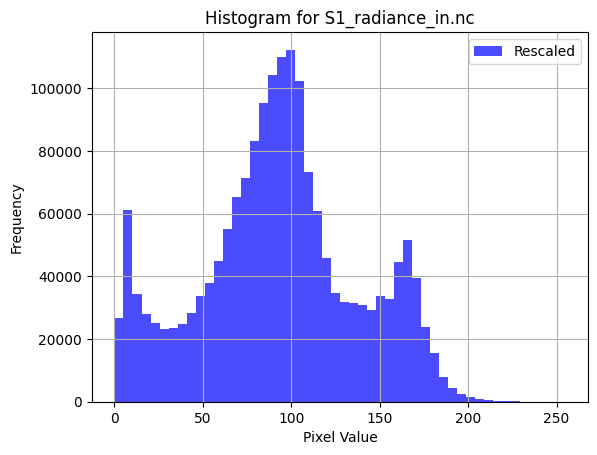

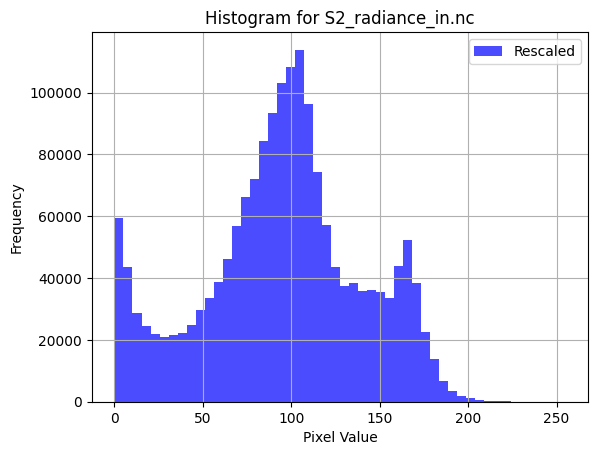

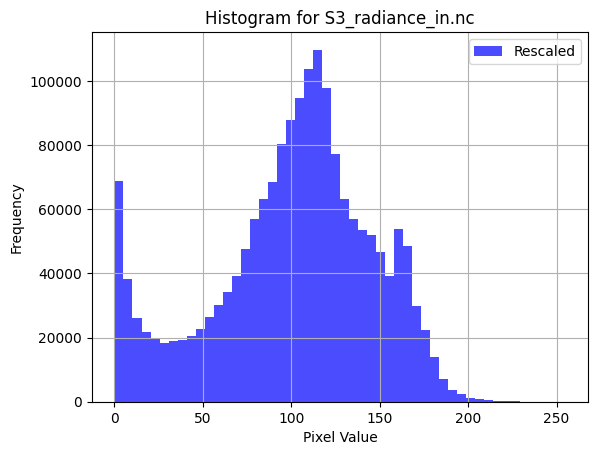

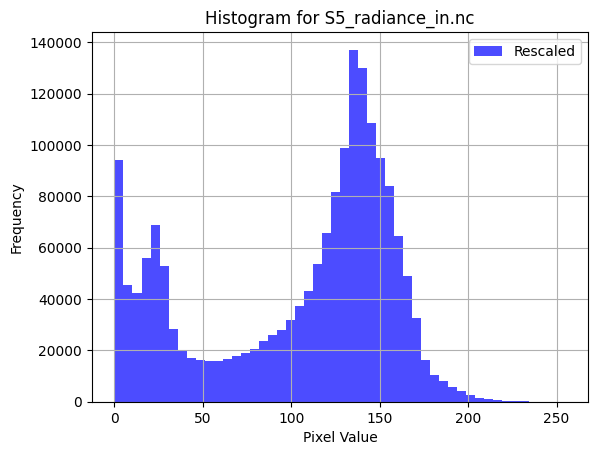

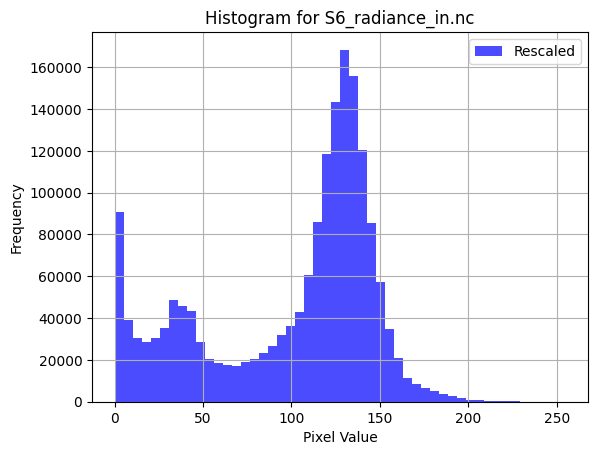

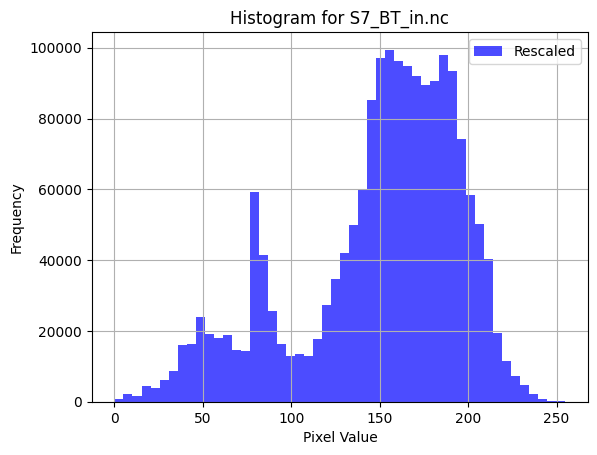

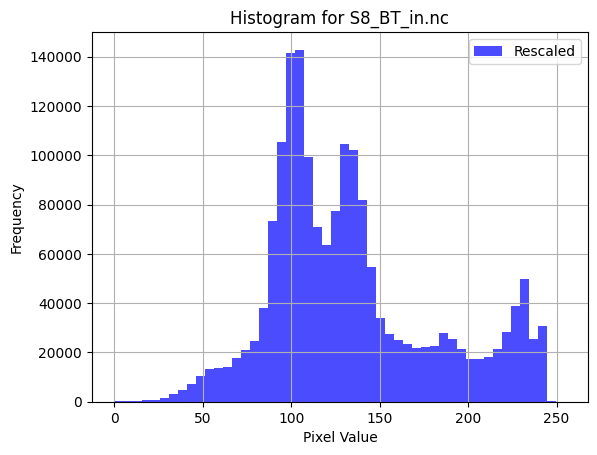

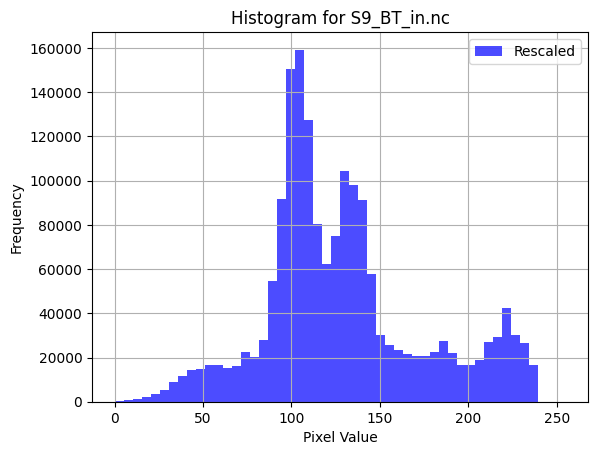

In [12]:
def plot_histogram(data, channel_name):
    plt.hist(data.values.flatten(), bins=50, color='blue', alpha=0.7, label='Rescaled')
    plt.title(f'Histogram for {channel_name}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

for idx, channel in enumerate(channels):
    plot_histogram(rescaled_data[idx], channel)


In [13]:
def print_descriptive_statistics(data, channel_name):
    print(f"Channel: {channel_name}")
    print(f"Mean: {np.nanmean(data.values.flatten())}")
    print(f"Median: {np.nanmedian(data.values.flatten())}")
    print(f"Standard Deviation: {np.nanstd(data.values.flatten())}")
    print(f"Min: {np.nanmin(data.values.flatten())}")
    print(f"Max: {np.nanmax(data.values.flatten())}")
    print("="*40)

for idx, channel in enumerate(channels):
    print_descriptive_statistics(rescaled_data[idx], channel)


Channel: S1_radiance_in.nc
Mean: 92.95129502037572
Median: 93.0968162104836
Standard Deviation: 44.92518945317022
Min: 0.0
Max: 254.99999055738812
Channel: S2_radiance_in.nc
Mean: 94.91934853588977
Median: 96.99553938320176
Standard Deviation: 45.03388217091839
Min: 0.0
Max: 254.99998961901858
Channel: S3_radiance_in.nc
Mean: 100.70442222376245
Median: 106.60950812046624
Standard Deviation: 45.44455437930482
Min: 0.0
Max: 254.99999566885236
Channel: S5_radiance_in.nc
Mean: 103.30317707193349
Median: 124.90403187450335
Standard Deviation: 54.80402050508893
Min: 0.0
Max: 255.00000411401155
Channel: S6_radiance_in.nc
Mean: 99.72584026525372
Median: 119.6735587501086
Standard Deviation: 48.49184022058845
Min: 0.0
Max: 254.99999641094817
Channel: S7_BT_in.nc
Mean: 149.86339921266844
Median: 159.61800552138038
Standard Deviation: 46.80848065317711
Min: 0.0
Max: 255.0
Channel: S8_BT_in.nc
Mean: 133.77624598927193
Median: 124.17704882140966
Standard Deviation: 47.56566375765648
Min: 0.0
Max: 2

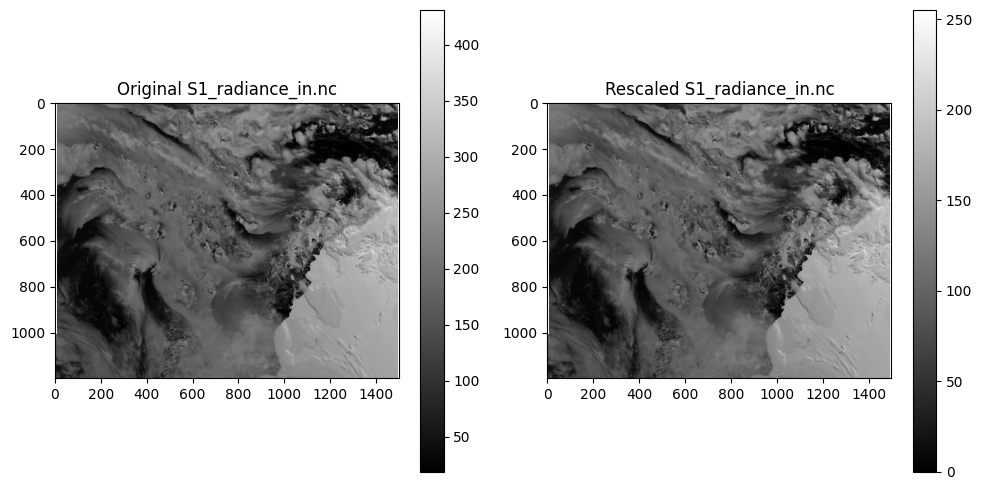

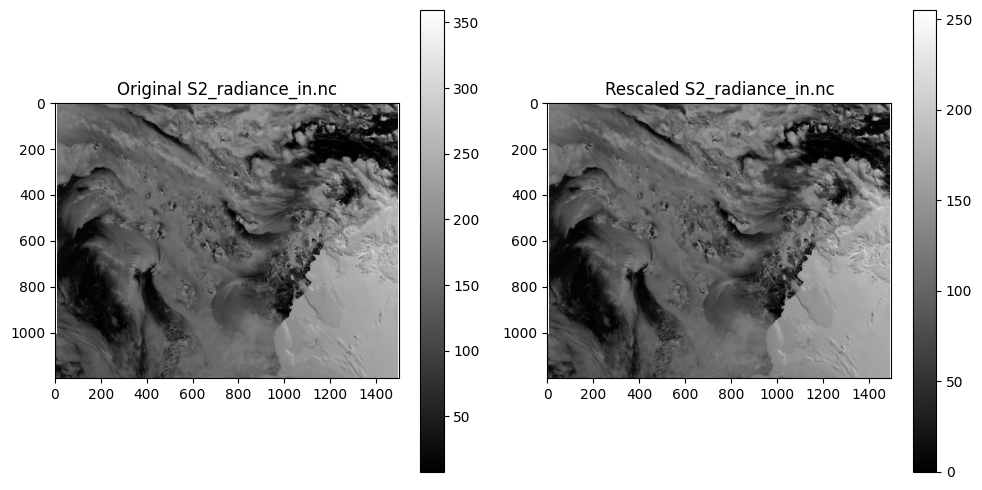

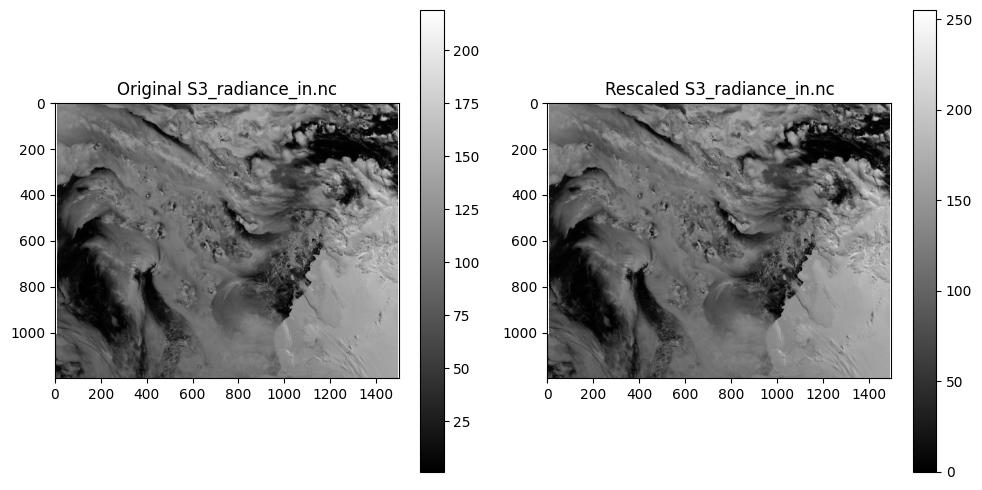

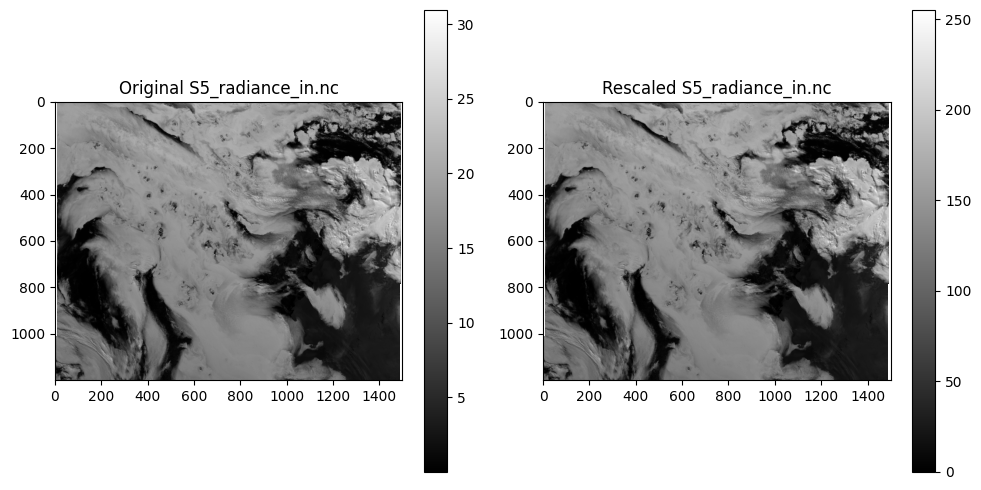

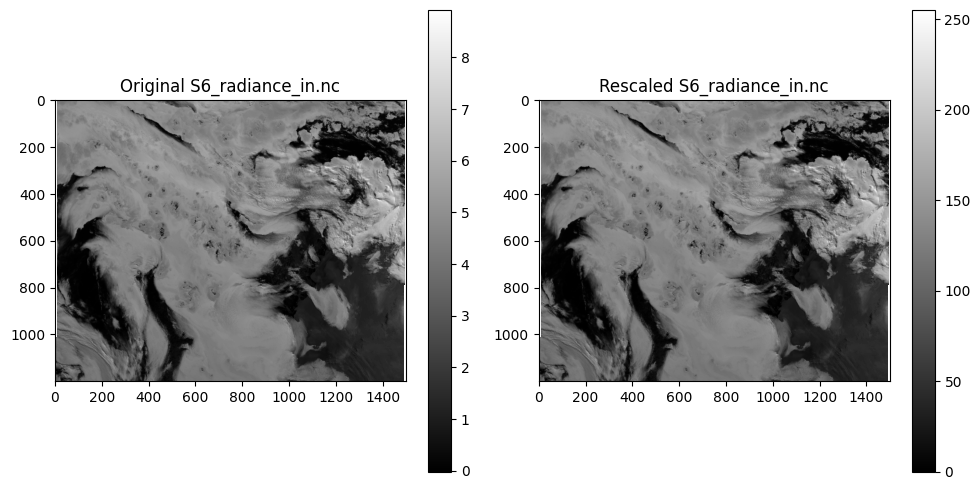

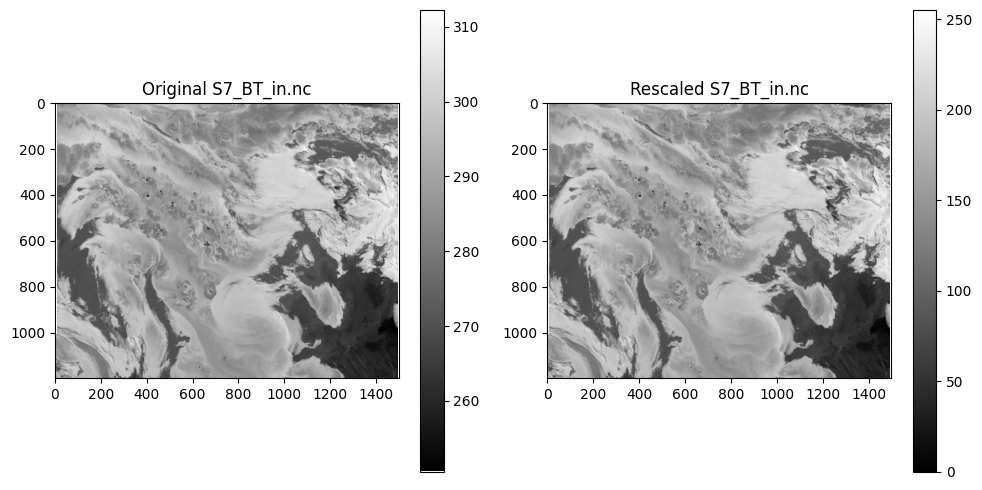

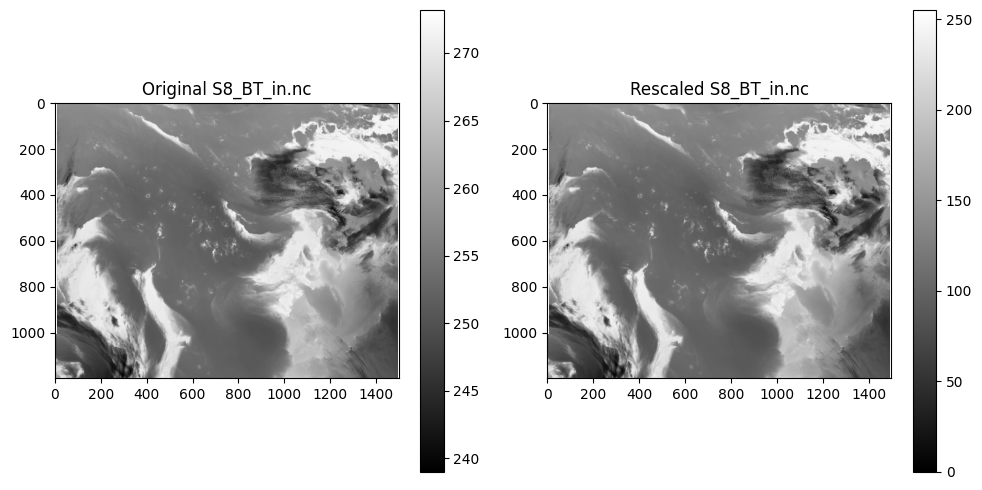

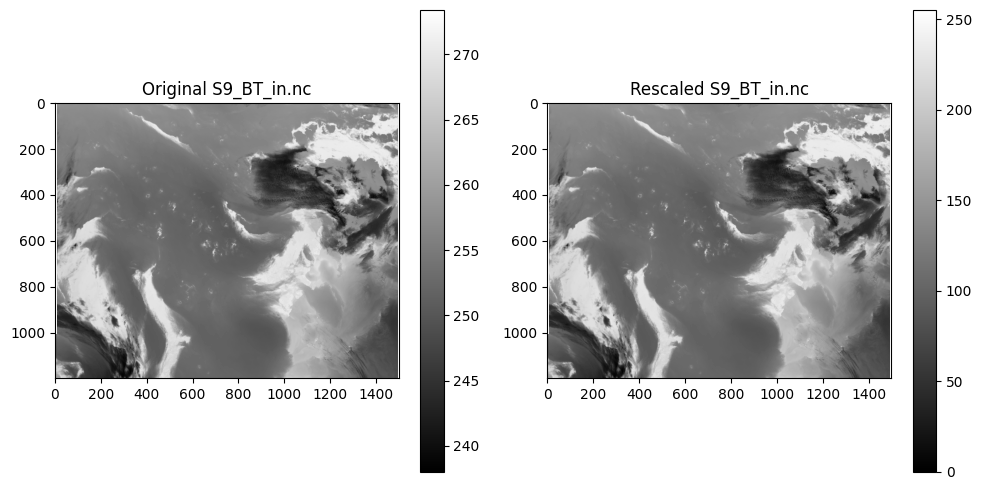

In [14]:
def plot_images(original, rescaled, channel_name):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    im1 = ax[0].imshow(original, cmap='gray')
    ax[0].set_title(f'Original {channel_name}')
    fig.colorbar(im1, ax=ax[0], orientation='vertical')
    
    im2 = ax[1].imshow(rescaled, cmap='gray')
    ax[1].set_title(f'Rescaled {channel_name}')
    fig.colorbar(im2, ax=ax[1], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

for idx, channel in enumerate(channels):
    plot_images(ds_combined[idx].values, rescaled_data[idx].values, channel)
